In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from skimage.io import imread

In [5]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [6]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\PNEUMONIA\person55_bacteria_2...,1
1,chest_xray\train\PNEUMONIA\person390_bacteria_...,1
2,chest_xray\train\PNEUMONIA\person5_bacteria_19...,1
3,chest_xray\train\NORMAL\NORMAL2-IM-1329-0001.jpeg,0
4,chest_xray\train\NORMAL\IM-0191-0001.jpeg,0


In [7]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,chest_xray\test\PNEUMONIA\person139_bacteria_6...,1
1,chest_xray\test\NORMAL\IM-0099-0001.jpeg,0
2,chest_xray\test\PNEUMONIA\person82_bacteria_40...,1
3,chest_xray\test\PNEUMONIA\person161_bacteria_7...,1
4,chest_xray\test\PNEUMONIA\person91_bacteria_44...,1


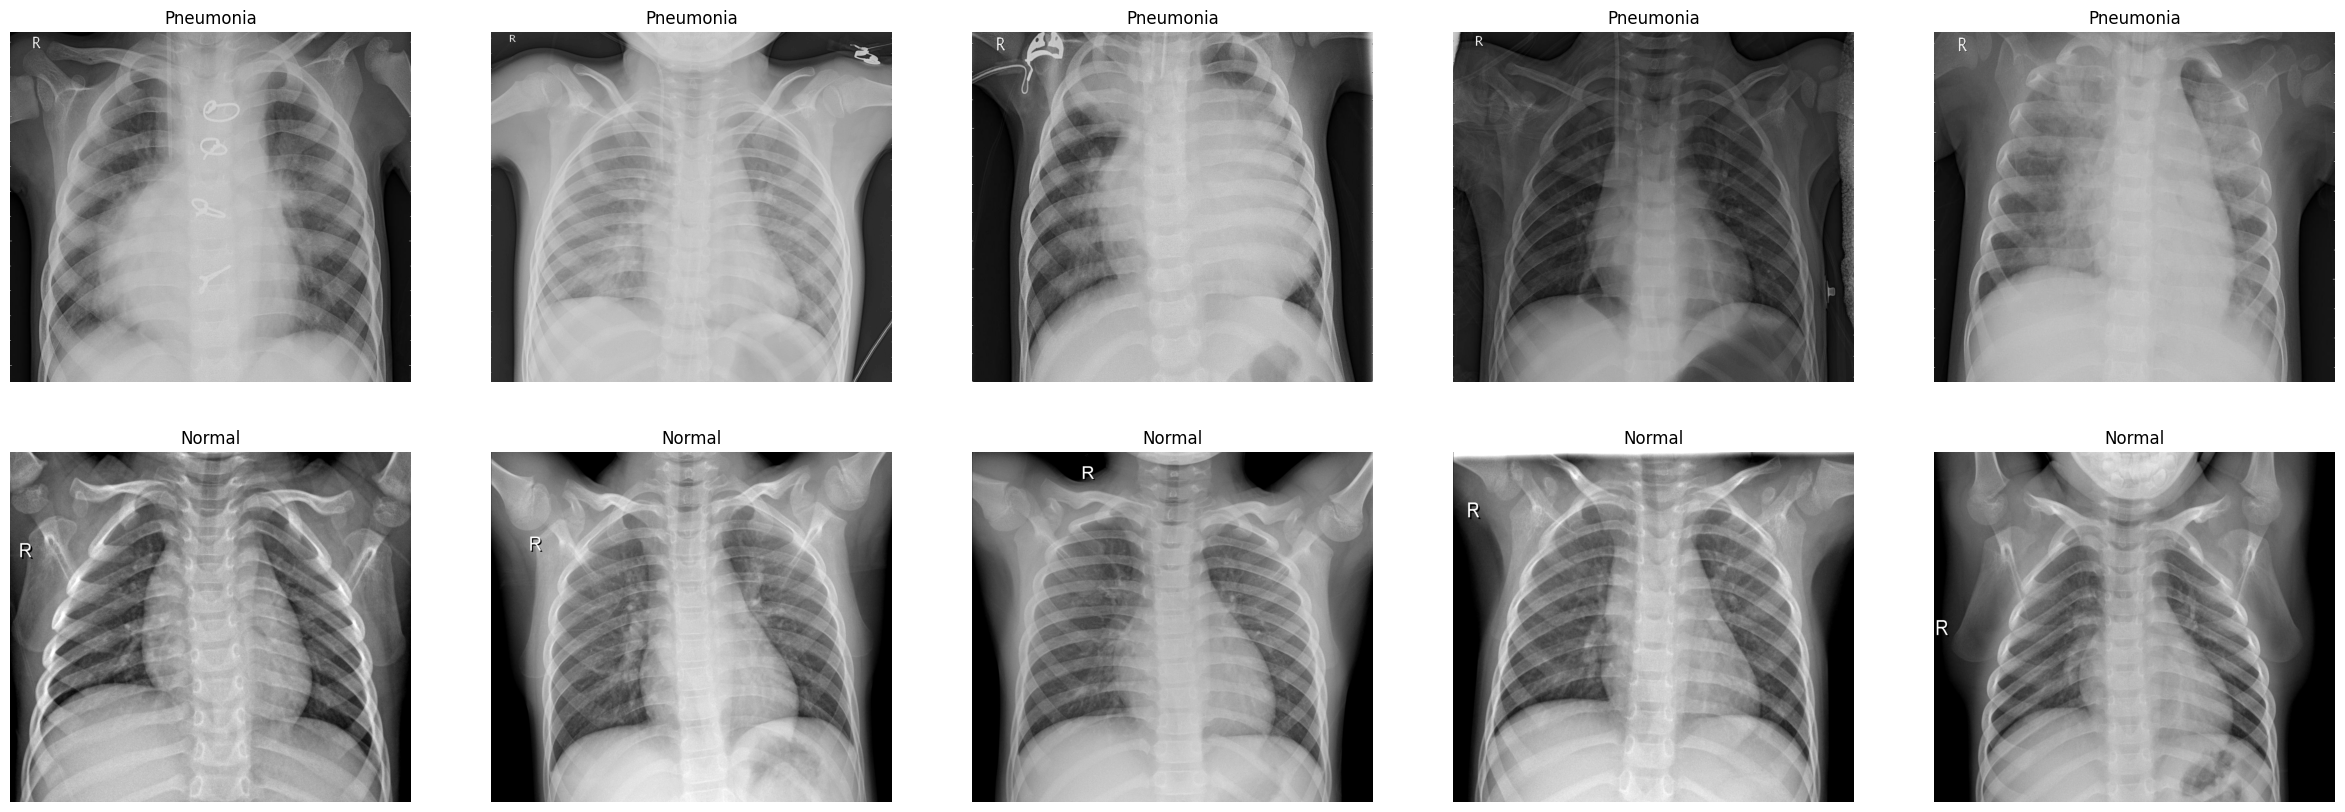

In [8]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [9]:
sizes = []
for imgPath in train_data['image']:
    img = imread(imgPath)
    size = img.shape
    sizes.append(size)

train_data['size'] = sizes
train_data

,image,label,size
0,chest_xray\train\PNEUMONIA\person55_bacteria_2...,1,"(880, 1256)"
1,chest_xray\train\PNEUMONIA\person390_bacteria_...,1,"(1440, 1544)"
2,chest_xray\train\PNEUMONIA\person5_bacteria_19...,1,"(776, 1160)"
3,chest_xray\train\NORMAL\NORMAL2-IM-1329-0001.jpeg,0,"(1175, 1438)"
4,chest_xray\train\NORMAL\IM-0191-0001.jpeg,0,"(1746, 2164)"
...,...,...,...
5211,chest_xray\train\NORMAL\IM-0633-0001.jpeg,0,"(1719, 1836)"
5212,chest_xray\train\PNEUMONIA\person1314_virus_22...,1,"(768, 1216)"
5213,chest_xray\train\PNEUMONIA\person651_bacteria_...,1,"(560, 904)"
5214,chest_xray\train\NORMAL\NORMAL2-IM-0988-0001.jpeg,0,"(1920, 1960)"


In [10]:
ratios = []
for size in train_data['size']:
  ratio = size[1] / size[0]
  ratios.append(ratio)

train_data['ratio'] = ratios
train_data

,image,label,size,ratio
0,chest_xray\train\PNEUMONIA\person55_bacteria_2...,1,"(880, 1256)",1.427273
1,chest_xray\train\PNEUMONIA\person390_bacteria_...,1,"(1440, 1544)",1.072222
2,chest_xray\train\PNEUMONIA\person5_bacteria_19...,1,"(776, 1160)",1.494845
3,chest_xray\train\NORMAL\NORMAL2-IM-1329-0001.jpeg,0,"(1175, 1438)",1.223830
4,chest_xray\train\NORMAL\IM-0191-0001.jpeg,0,"(1746, 2164)",1.239404
...,...,...,...,...
5211,chest_xray\train\NORMAL\IM-0633-0001.jpeg,0,"(1719, 1836)",1.068063
5212,chest_xray\train\PNEUMONIA\person1314_virus_22...,1,"(768, 1216)",1.583333
5213,chest_xray\train\PNEUMONIA\person651_bacteria_...,1,"(560, 904)",1.614286
5214,chest_xray\train\NORMAL\NORMAL2-IM-0988-0001.jpeg,0,"(1920, 1960)",1.020833
